In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lung_map_utils import utils
from lung_map_utils_extra import utils_extra

%matplotlib inline

In [2]:
fig_size = (12, 12)

img_file = "data/2015-004-030_20X_C57BL6_E18.5_LMM.14.27.6.53_SOX9_SFTPC_ACTA2_004.tif"
#img_file = "data/mouse_16.5_20x/LMEX0000000073_acta2_sftpc_sox9/2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_001.tif"
img = cv2.imread(img_file)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
img_s = img_hsv[:, :, 1]

img_shape = (img.shape[0], img.shape[1])

In [3]:
large_blur_kernel = (95, 95)
med_blur_kernel = (63, 63)
small_blur_kernel = (31, 31)

cross_strel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

ellipse_strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
ellipse90_strel = np.rot90(ellipse_strel)

circle_strel = np.bitwise_or(ellipse_strel, ellipse90_strel)

### Functions

In [4]:
def find_border_by_mask(signal_mask, contour_mask, max_dilate_percentage=0.2, dilate_iterations=1):
    area = np.sum(contour_mask > 0)
    max_dilation_area = area + int(max_dilate_percentage * area)
    
    # create a baseline from the original border
    filled_c_mask_erode = cv2.erode(
        contour_mask, 
        circle_strel, 
        iterations=dilate_iterations
    )
    border_mask = contour_mask - filled_c_mask_erode
    border_signal_mask = np.bitwise_and(border_mask, signal_mask)
    
    max_mask = contour_mask.copy()
    max_signal = np.sum(border_signal_mask > 0) / np.sum(border_mask > 0)
    orig = True
    
    filled_c_mask_dilate = contour_mask.copy()
    
#     print(max_signal)
    count = 0
    
    while area < max_dilation_area:
        count += 1
        
        last_mask = filled_c_mask_dilate.copy()
        filled_c_mask_dilate = cv2.dilate(last_mask, circle_strel, iterations=dilate_iterations)
        area = np.sum(filled_c_mask_dilate > 0)
        border_mask = filled_c_mask_dilate - last_mask
        border_signal_mask = np.bitwise_and(border_mask, signal_mask)

        new_signal = np.sum(border_signal_mask > 0) / np.sum(border_mask > 0)
#         print(new_signal)
        
        if max_signal > 0 and new_signal == 0 and count > 5:
            break
        
        if new_signal >= max_signal:
            max_signal = new_signal
            max_mask = filled_c_mask_dilate.copy()
            orig = False
            
    return max_mask, max_signal, orig

### Pre-processing

Instead of removing the "blue" pixels, just remove the blue from ALL the pixels. This essentially enhances any edges without any blurring or magic numbers.

In [5]:
b_over_r = img_rgb[:, :, 0] < img_rgb[:, :, 2]
b_over_g = img_rgb[:, :, 1] < img_rgb[:, :, 2]

b_over_rg = np.bitwise_and(b_over_r, b_over_g)

b_replace = np.max([img_rgb[:, :, 0], img_rgb[:, :, 1]], axis=0)

b_suppress_img = img_rgb.copy()
b_suppress_img[b_over_rg, 2] = b_replace[b_over_rg]
b_suppress_img_hsv = cv2.cvtColor(b_suppress_img, cv2.COLOR_RGB2HSV)

enhanced_v_img = b_suppress_img_hsv[:, :, 2]

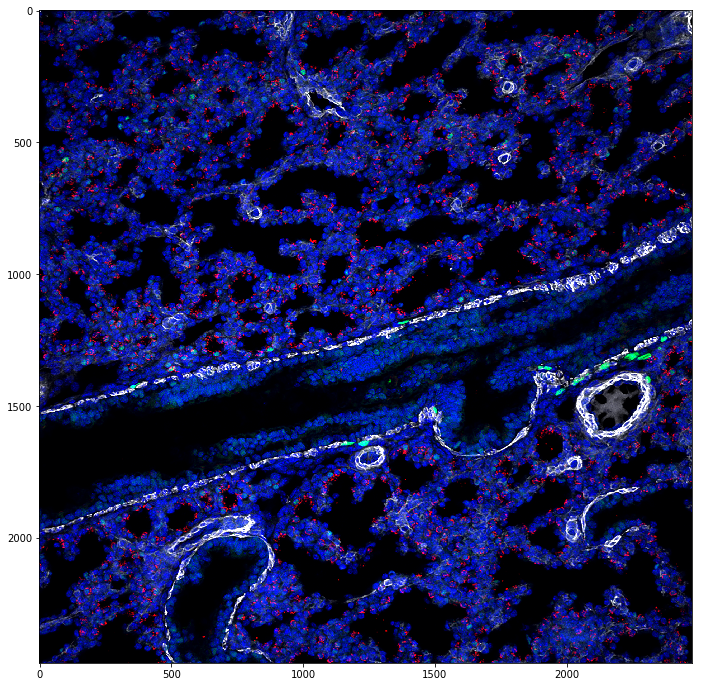

In [6]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_rgb)

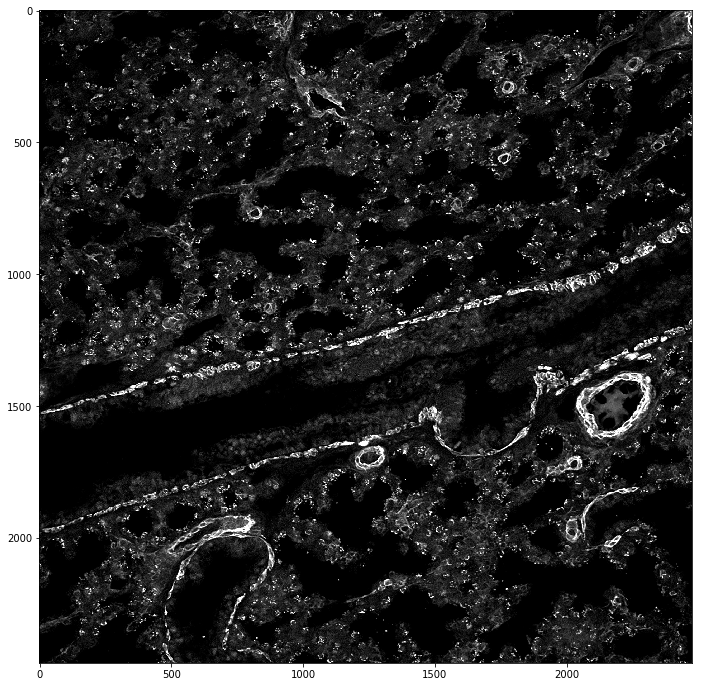

In [122]:
fig = plt.figure(figsize=fig_size)
plt.imshow(enhanced_v_img, cmap='gray')

In [123]:
# diff of gaussians
img_blur_1 = cv2.blur(enhanced_v_img, (15, 15))
img_blur_2 = cv2.blur(enhanced_v_img, (127, 127))

tmp_img_1 = img_blur_1.astype(np.int16)
tmp_img_2 = img_blur_2.astype(np.int16)

edge_mask = tmp_img_2 - tmp_img_1
edge_mask[edge_mask > 0] = 0
edge_mask[edge_mask < 0] = 255

edge_mask = edge_mask.astype(np.uint8)

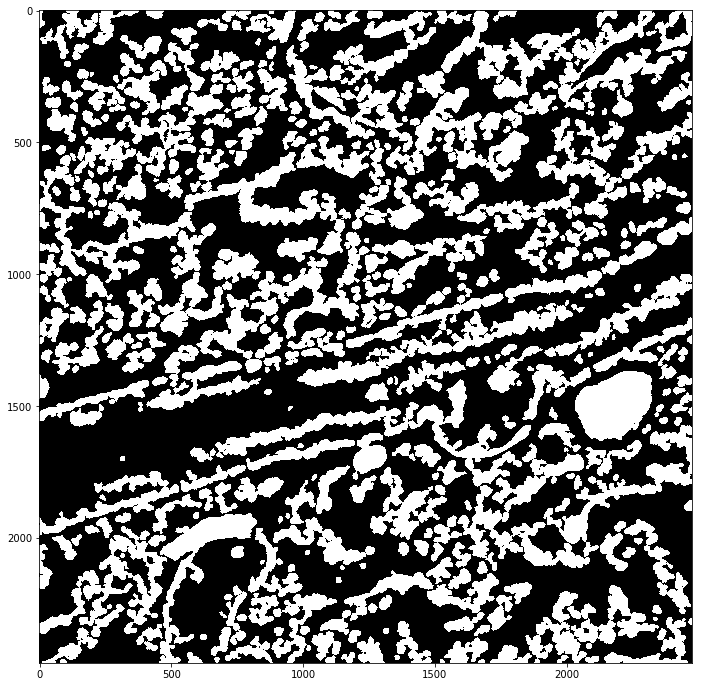

In [124]:
contours = utils_extra.filter_contours_by_size(edge_mask, min_size=15*15)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, cross_strel, iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

### Color candidates

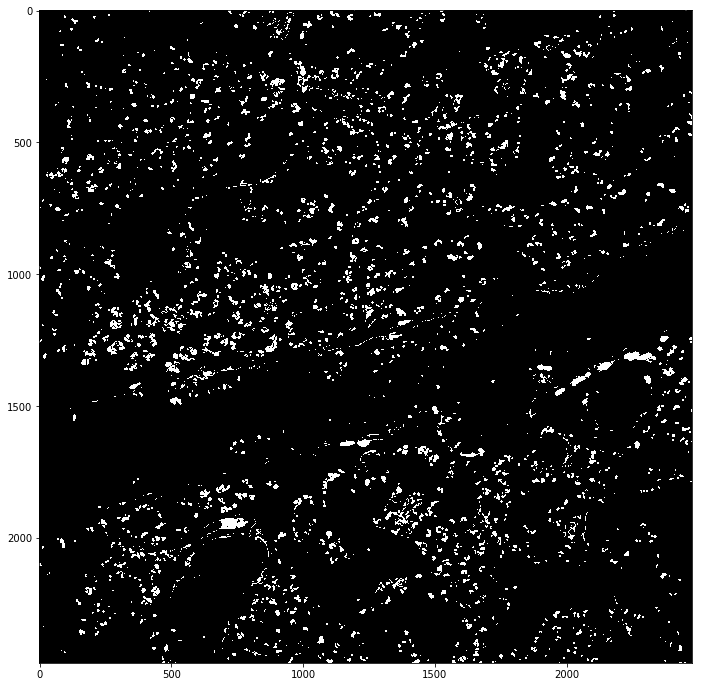

In [125]:
# blur the blue suppressed image just slightly to connect 
# adjacent cells of the same structure
tmp_color_img = cv2.cvtColor(b_suppress_img_hsv, cv2.COLOR_HSV2RGB)
tmp_color_img = cv2.blur(tmp_color_img, (9, 9))
tmp_color_img = cv2.cvtColor(tmp_color_img, cv2.COLOR_RGB2HSV)

color_mask = utils.create_mask(
    tmp_color_img,
    [
        'green', 'cyan', 'red', 'violet', 'yellow'
    ]
)

color_mask = cv2.bitwise_and(color_mask, color_mask, mask=edge_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(color_mask, cmap='gray')

In [126]:
# Next, clean up any "noise", say, ~ 5 x 5
contours = utils_extra.filter_contours_by_size(color_mask, min_size=5*5)

color_mask2 = np.zeros(img_shape, dtype=np.uint8)
color_mask2 = cv2.drawContours(color_mask2, contours, -1, 255, -1)

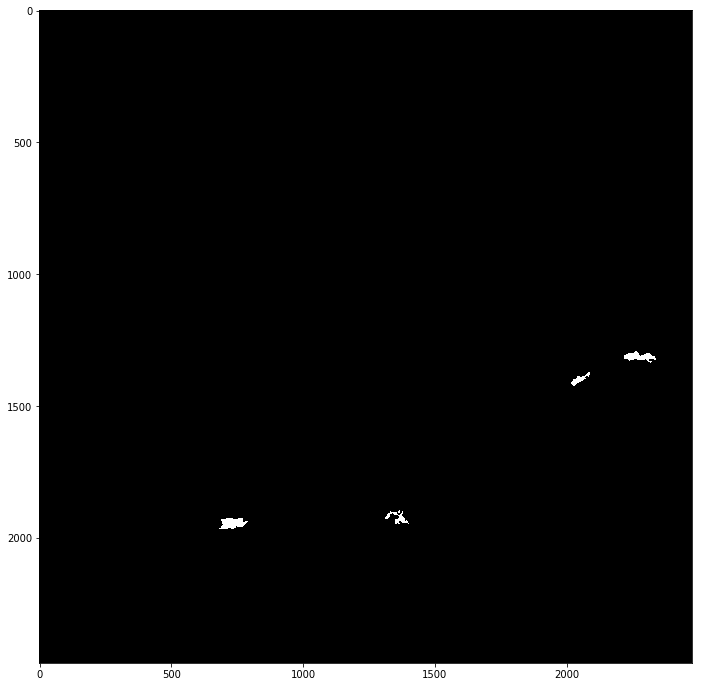

In [127]:
# do a couple dilations to smooth some outside edges & connect any adjacent cells each other
color_mask3 = cv2.dilate(color_mask2, cross_strel, iterations=2)

# do a couple dilations to smooth some outside edges & connect any adjacent cells each other
color_mask3 = cv2.erode(color_mask3, cross_strel, iterations=3)

# filter out any remaining contours that are the size of roughly 2 cells
contours = utils_extra.filter_contours_by_size(color_mask3, min_size=2*40*40)

color_mask3 = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(color_mask3, contours, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(color_mask3, cmap='gray')

In [128]:
len(contours)

4

In [129]:
good_color_contours = []

for i, c in enumerate(contours):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = find_border_by_mask(
        edge_mask, 
        filled_c_mask, 
        max_dilate_percentage=0.3,
        dilate_iterations=1
    )
    
    print('\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        good_color_contours.append(contours[0])
    elif orig and signal > 0.7:
        good_color_contours.append(c)
    else:
        pass  # don't include contour

# 0 #
	 1.0
# 1 #
	 1.0
# 2 #
	 1.0
# 3 #
	 1.0


In [130]:
len(good_color_contours)

4

In [131]:
# The previous contours represent the final count of contours for the color group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next 2 groups of candidates
final_color_contours = []

for c in good_color_contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.007 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.erode(single_cnt_mask, np.ones((3, 3)), iterations=1)
    single_cnt_mask = cv2.dilate(single_cnt_mask, np.ones((3, 3)), iterations=8)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    if len(tmp_contours) > 0:
        final_color_contours.append(tmp_contours[0])

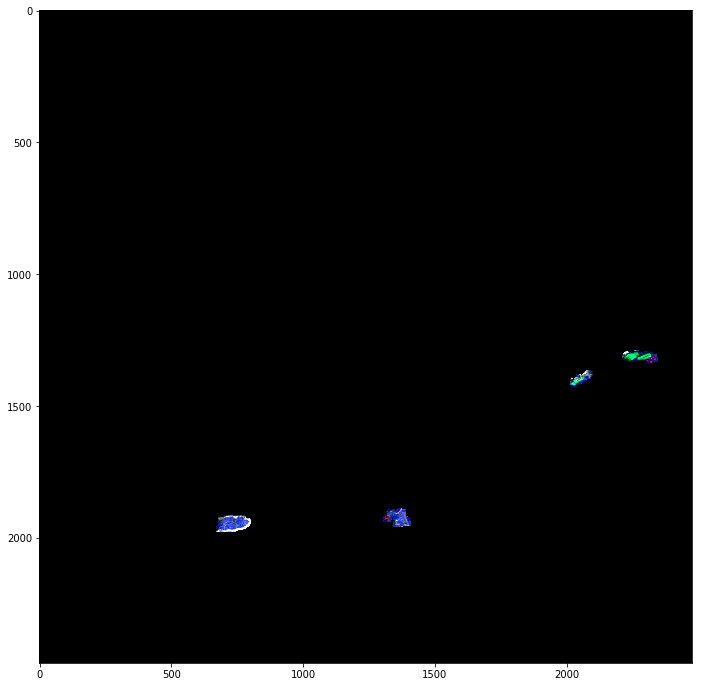

In [132]:
# final color mask to use for exclusion from further groups
final_color_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_color_mask, final_color_contours, -1, 255, -1)

final_color_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_color_img)

### The broken border problem

The fact is, border markers (usu. muscle?) are typically either broken (larger structures) or quite thin (smaller structures). This poses a problem for any thresholding based segmentation approach. Applying any blurring techniques involves choosing arbitrary kernel sizes. Any dilation approach, even "smart" techniques of extending eccentric contours or bridging using custom convolution kernels also requires arbitrary choices and inevitably bridges some adjacent structures together.

What can be found is the center regions via saturation, which can then be dilated by a simple 3x3 kernel one iteration at a time to measure the border intensity of this expanding ring. Regardless of whether a border is broken or thin, this will still yield a closed structure.

#### Large sat-val candidates

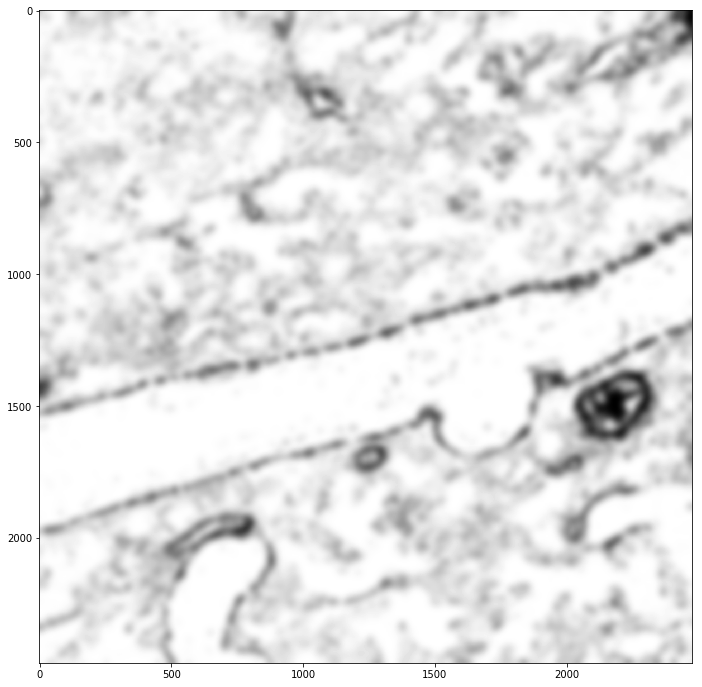

In [133]:
# start large structure saturation candidates
img_s_large_blur = cv2.GaussianBlur(img_s, large_blur_kernel, 0, 0)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_large_blur, cmap='gray')

In [134]:
med = np.median(img_s_large_blur[img_s_large_blur > 0])

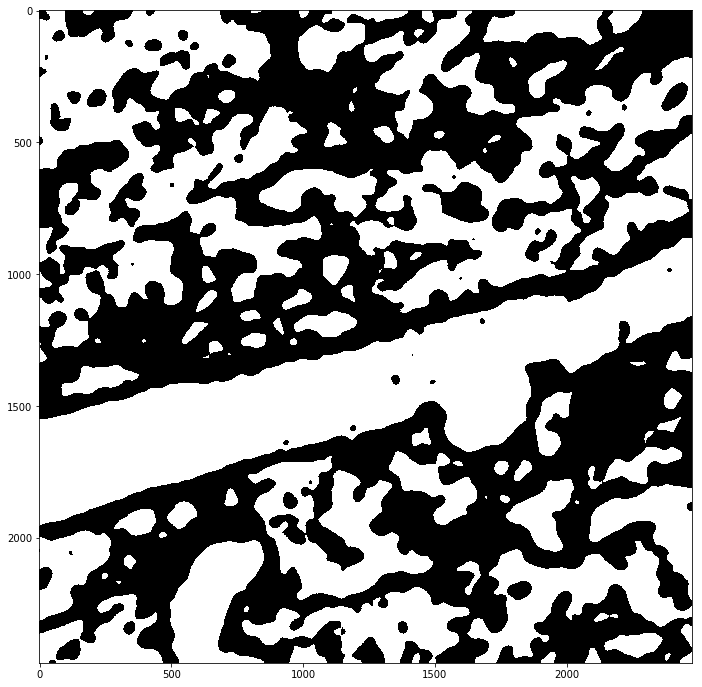

In [135]:
img_s_large_blur = cv2.bitwise_and(img_s_large_blur, img_s_large_blur, mask=~final_color_mask)
mode_s_large = cv2.inRange(img_s_large_blur, med, 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_large, cmap='gray')

In [136]:
mode_s_large = cv2.erode(mode_s_large, cross_strel, iterations=5)

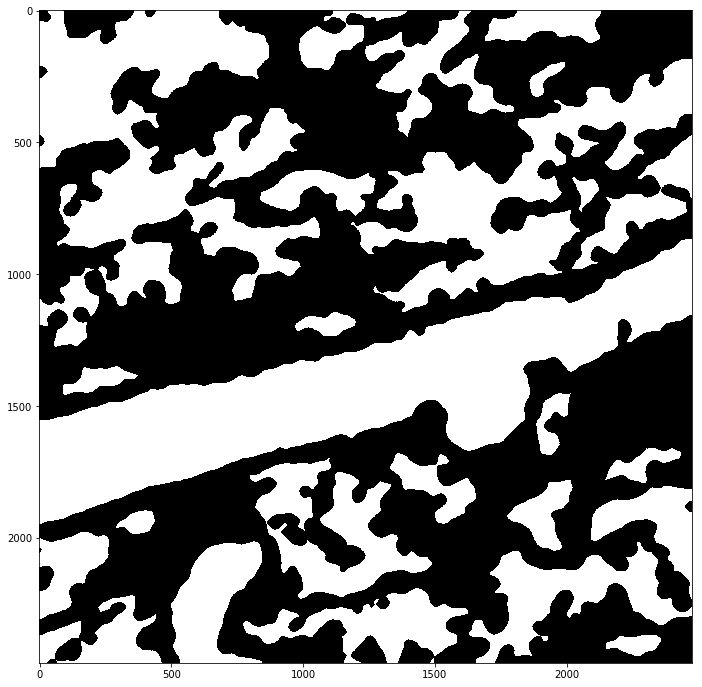

In [137]:
good_contours_large = utils_extra.filter_contours_by_size(
    mode_s_large,
    min_size=10 * 32 * 32,
    max_size=(img.shape[0] * img.shape[1]) * .5
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_large, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

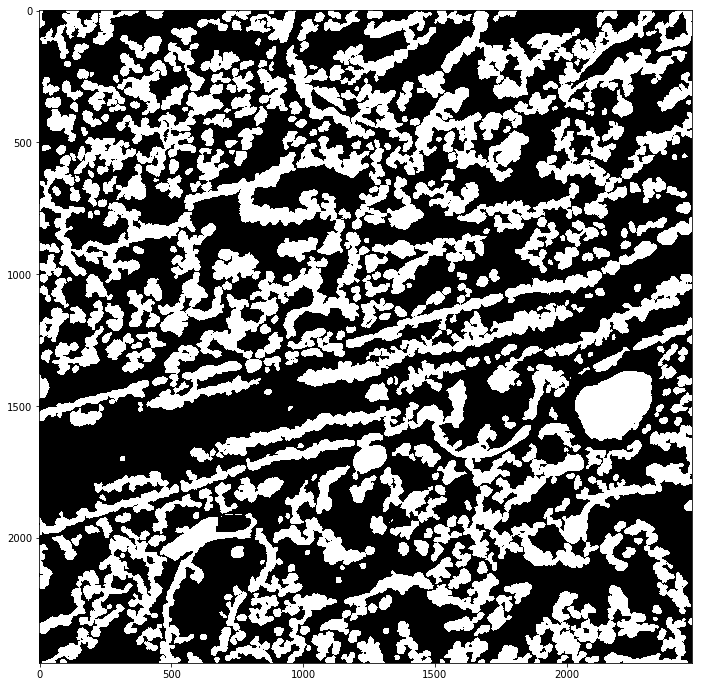

In [138]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

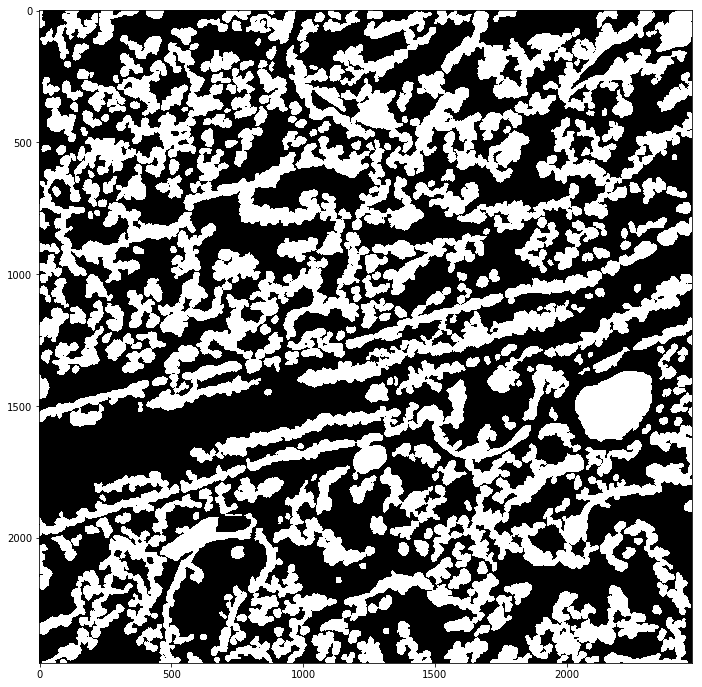

In [139]:
contours = utils_extra.filter_contours_by_size(edge_mask, min_size=21*21)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [140]:
good_large_sat_val_contours = []

for i, c in enumerate(good_contours_large):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=2.0,
        dilate_iterations=1
    )
    
    print(signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        good_large_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        good_large_sat_val_contours.append(c)
    else:
        pass  # ignore contour

# 0 #
0.7876811594202898
# 1 #
0.8566775244299675
# 2 #
0.711144806671721
# 3 #
0.7786576915462284
# 4 #
0.7664254292606782
# 5 #
0.9427356020942408
# 6 #
0.781071242849714
# 7 #
0.7259036144578314
# 8 #
0.8945357279327474
# 9 #
0.7529518619436876
# 10 #
0.7994372990353698
# 11 #
0.7131542699724518
# 12 #
0.860246913580247
# 13 #
0.6426299045599152
# 14 #
0.6591858037578288
# 15 #
0.7741243745532523
# 16 #
0.7005327245053272
# 17 #
0.9117029862792575
# 18 #
0.7792985457656116
# 19 #
0.8609047940580689
# 20 #
0.7239400701306982
# 21 #
0.8341384863123994
# 22 #
0.7480210204217388
# 23 #
0.8302094818081588
# 24 #
0.789746158984636
# 25 #
0.7641462193289935
# 26 #
0.7481792568178194


In [141]:
len(good_large_sat_val_contours)

25

In [142]:
# The previous contours represent the final count of contours for the large sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
final_large_sat_val_contours = []

for c in good_large_sat_val_contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.0035 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, circle_strel, iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_large_sat_val_contours.append(tmp_contours[0])

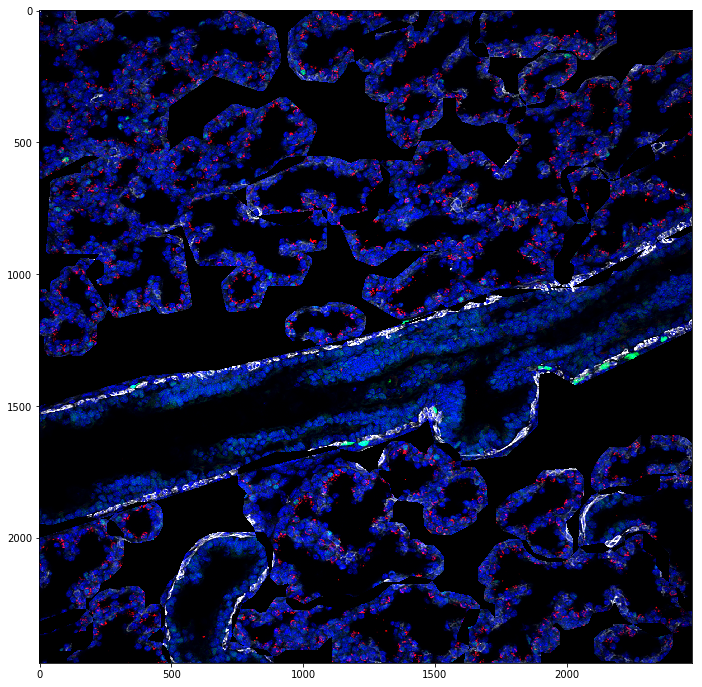

In [143]:
# final color mask to use for exclusion from further groups
final_large_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_large_sat_val_mask, final_large_sat_val_contours, -1, 255, -1)

large_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(large_sat_val_img)

#### Medium sat-val candidates

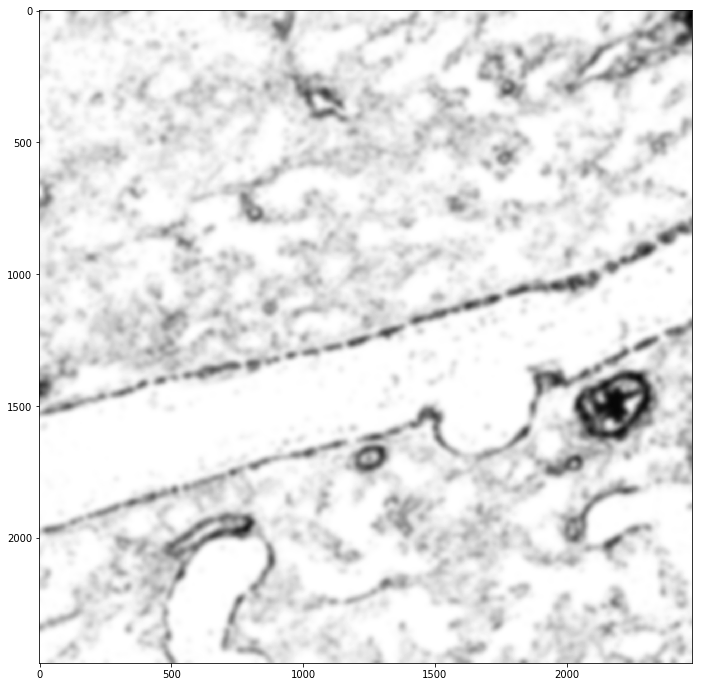

In [144]:
# start medium structure saturation candidates
img_s_medium_blur = cv2.GaussianBlur(img_s, med_blur_kernel, 0, 0)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_medium_blur, cmap='gray')

In [145]:
med = np.median(img_s_medium_blur[img_s_medium_blur > 0])

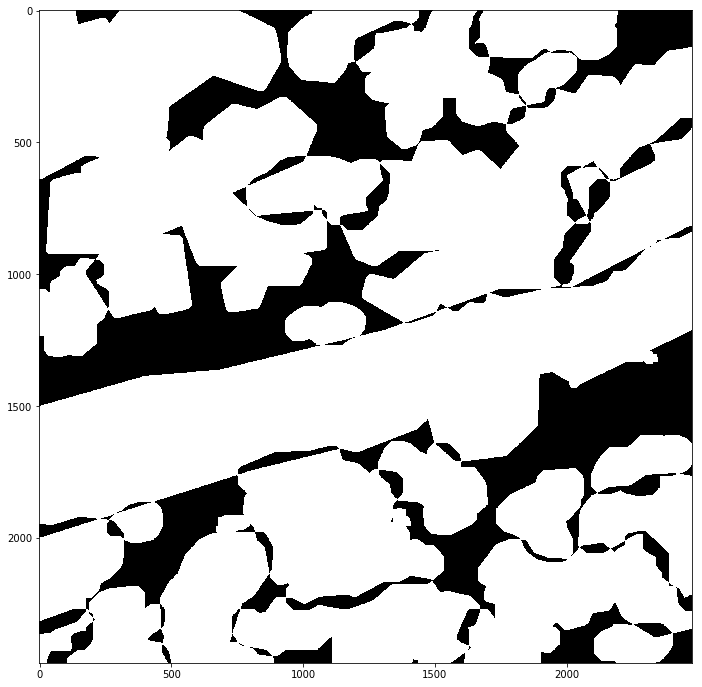

In [146]:
# make intermediate candidate mask
tmp_candidate_mask = np.bitwise_or(final_color_mask, final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_candidate_mask, cmap='gray')

In [147]:
img_s_medium_blur = cv2.bitwise_and(img_s_medium_blur, img_s_medium_blur, mask=~tmp_candidate_mask)

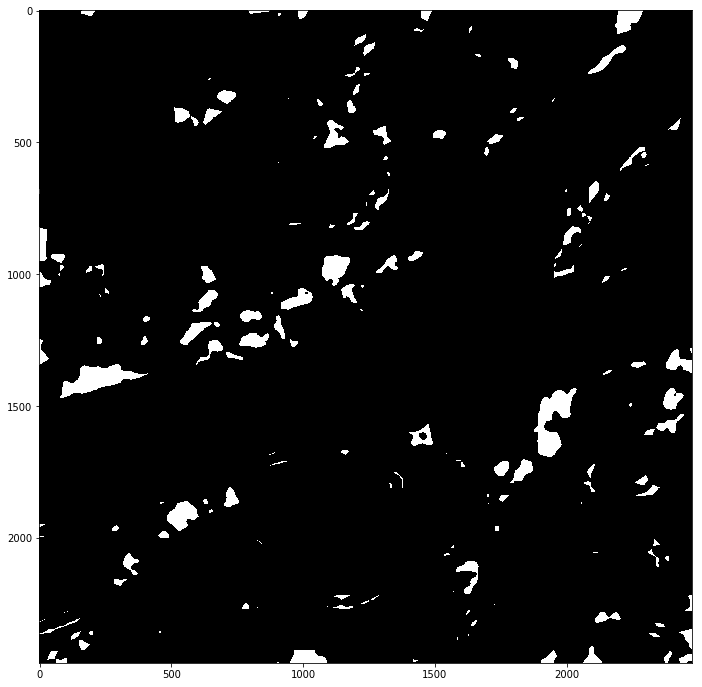

In [148]:
mode_s_med = cv2.inRange(img_s_medium_blur, np.ceil(med), 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_med, cmap='gray')

In [149]:
mode_s_med = cv2.erode(mode_s_med, cross_strel, iterations=8)

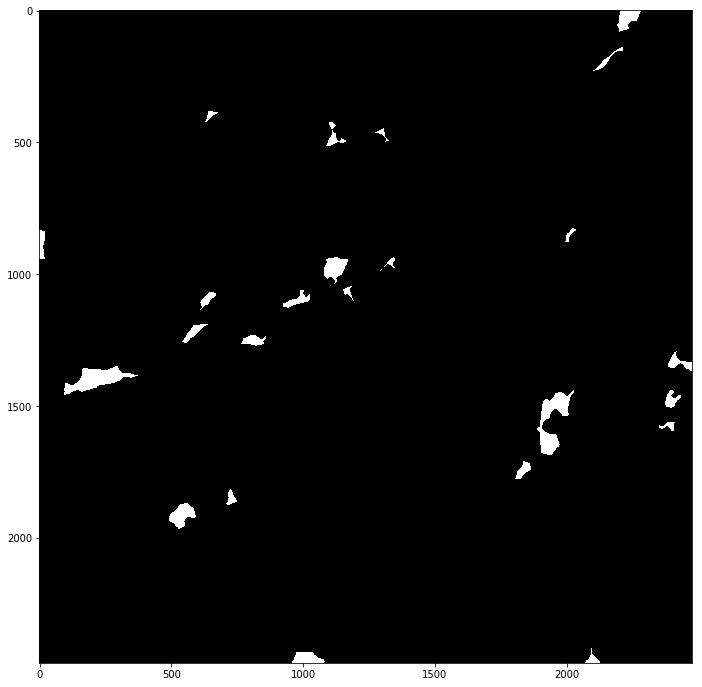

In [150]:
good_contours_med = utils_extra.filter_contours_by_size(
    mode_s_med,
    min_size=2*32 * 32,
    max_size=(img.shape[0] * img.shape[1]) * .125
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_med, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

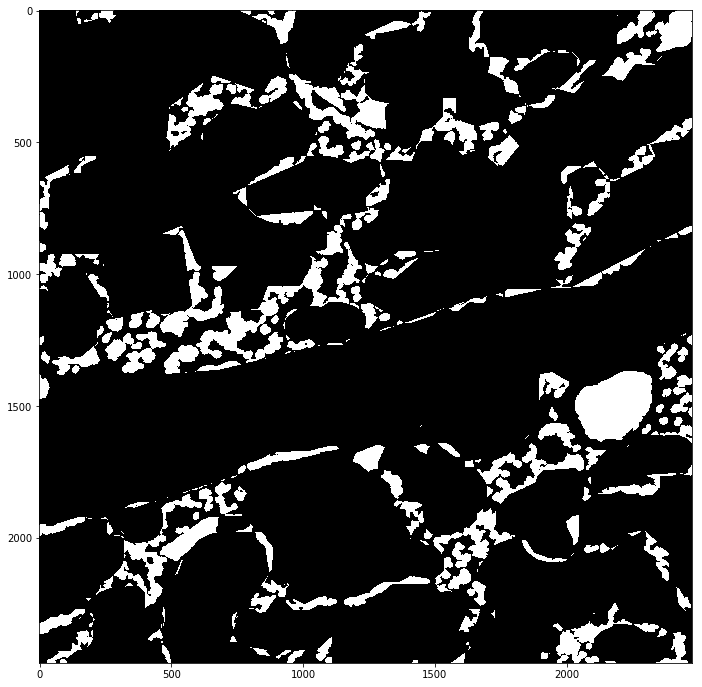

In [151]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_large_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

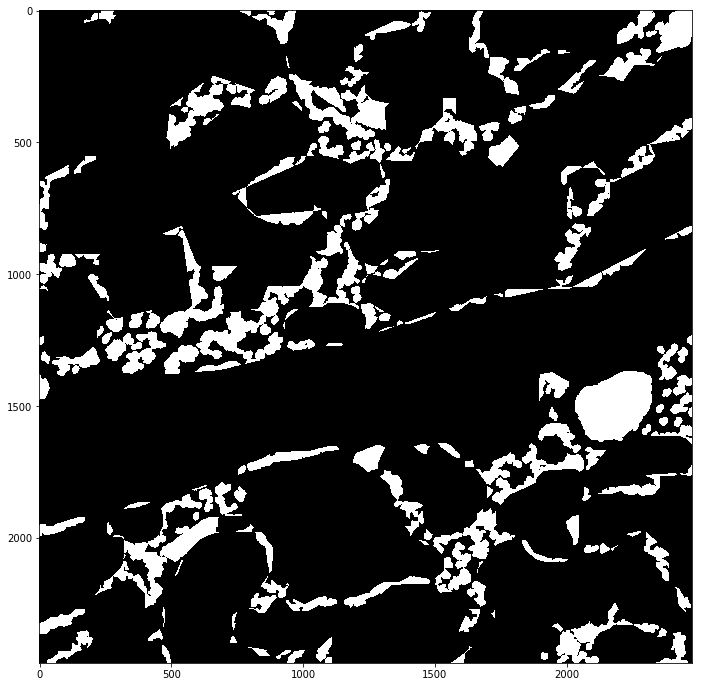

In [152]:
contours = utils_extra.filter_contours_by_size(edge_mask, min_size=21*21)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [153]:
final_med_sat_val_contours = []

for i, c in enumerate(good_contours_med):
    print('#', i, '#')
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=1.5,
        dilate_iterations=1
    )
    
    print('\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        final_med_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        final_med_sat_val_contours.append(c)
    else:
        pass  # ignore contour

# 0 #
	 0.6216867469879518
# 1 #
	 0.4154929577464789
# 2 #
	 0.6292397660818714
# 3 #
	 0.6881496881496881
# 4 #
	 0.411371237458194
# 5 #
	 0.3525773195876289
# 6 #
	 0.6342281879194631
# 7 #
	 0.4334677419354839
# 8 #
	 0.23868082727780884
# 9 #
	 0.5762195121951219
# 10 #
	 0.4248927038626609
# 11 #
	 0.06712328767123288
# 12 #
	 0.6523972602739726
# 13 #
	 0.3194805194805195
# 14 #
	 0.5738396624472574
# 15 #
	 0.7664543524416136
# 16 #
	 0.16432865731462926
# 17 #
	 0.43908045977011495
# 18 #
	 0.5955882352941176
# 19 #
	 0.26126126126126126
# 20 #
	 0.43818849449204406
# 21 #
	 0.6650717703349283
# 22 #
	 0.0
# 23 #
	 0.6084905660377359


In [154]:
len(final_med_sat_val_contours)

1

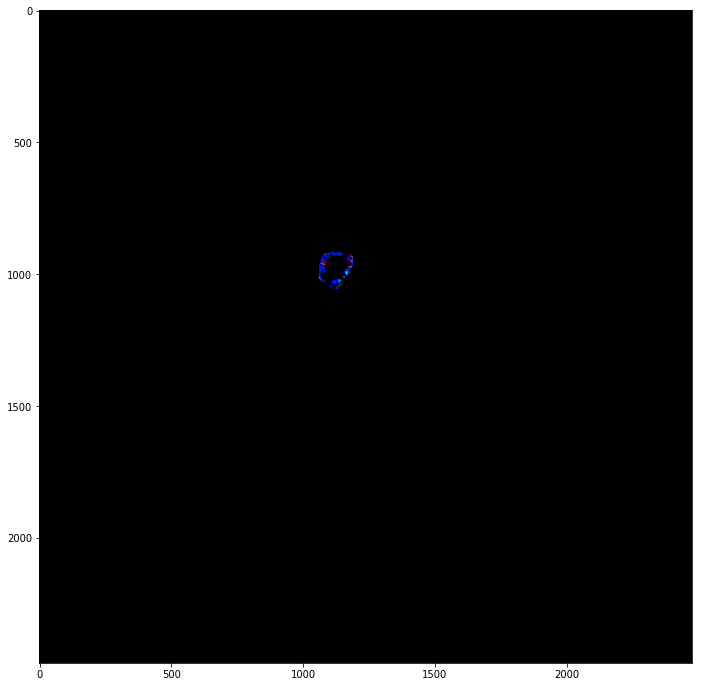

In [155]:
med_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(med_sat_val_mask, final_med_sat_val_contours, -1, 255, cv2.FILLED)

med_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(med_sat_val_img)

In [156]:
# The previous contours represent the final count of contours for the med sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
_, contours, _ = cv2.findContours(
    med_sat_val_mask,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

final_med_sat_val_contours = []

for c in contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.0035 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, circle_strel, iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_med_sat_val_contours.append(tmp_contours[0])

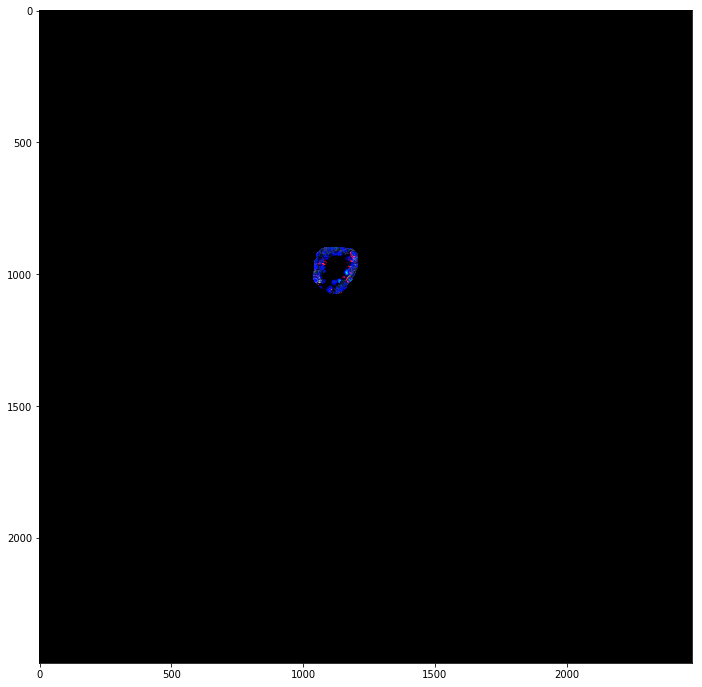

In [157]:
# final color mask to use for exclusion from further groups
final_med_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_med_sat_val_mask, final_med_sat_val_contours, -1, 255, -1)

med_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(med_sat_val_img)

#### Small sat-val candidates

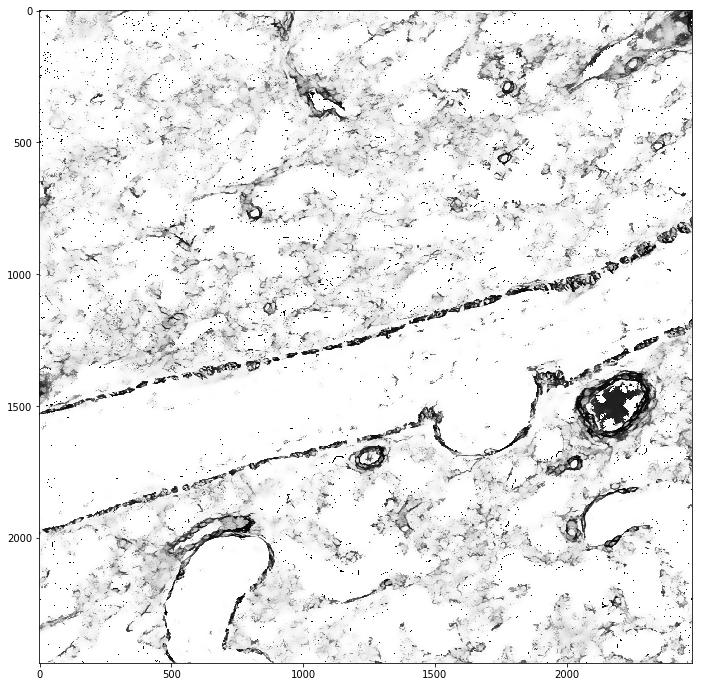

In [158]:
# start large structure saturation candidates
img_s_small_blur = cv2.bilateralFilter(img_s, small_blur_kernel[0], 31, 31)

fig = plt.figure(figsize=fig_size)
plt.imshow(img_s_small_blur, cmap='gray')

In [159]:
med = np.median(img_s_small_blur[img_s_small_blur > 0])

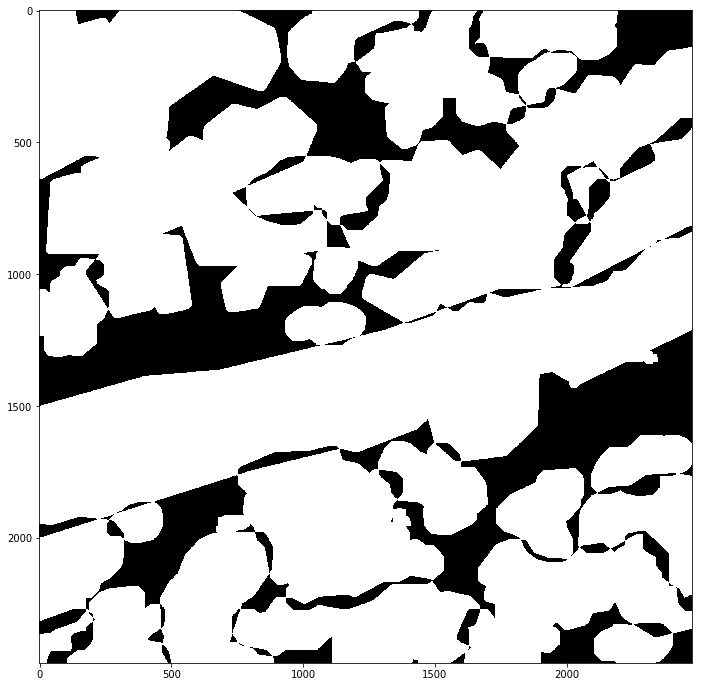

In [160]:
# make intermediate candidate mask
tmp_candidate_mask = np.bitwise_or(tmp_candidate_mask, final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_candidate_mask, cmap='gray')

In [161]:
img_s_small_blur = cv2.bitwise_and(img_s_small_blur, img_s_small_blur, mask=~tmp_candidate_mask)

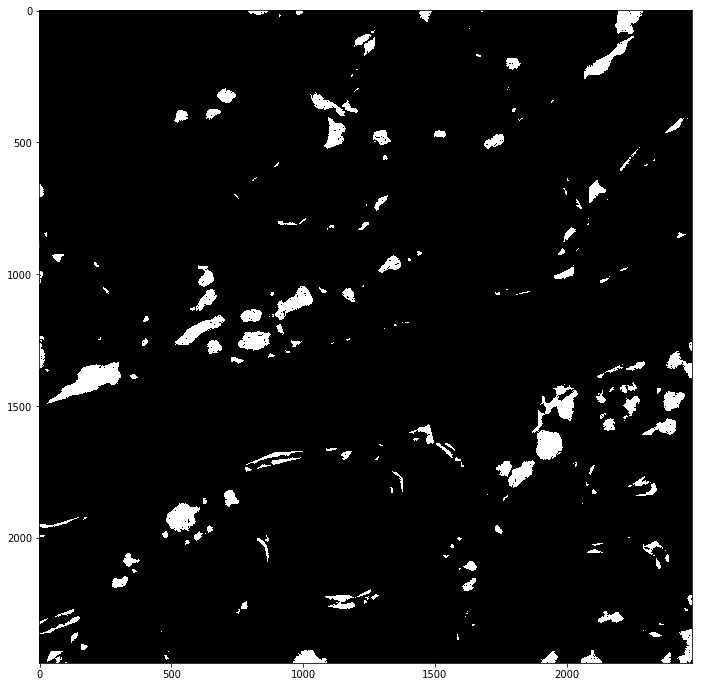

In [162]:
mode_s_small = cv2.inRange(img_s_small_blur, np.ceil(med), 255)

fig = plt.figure(figsize=fig_size)
plt.imshow(mode_s_small, cmap='gray')

In [163]:
mode_s_small = cv2.erode(mode_s_small, np.ones((3, 3)), iterations=2)

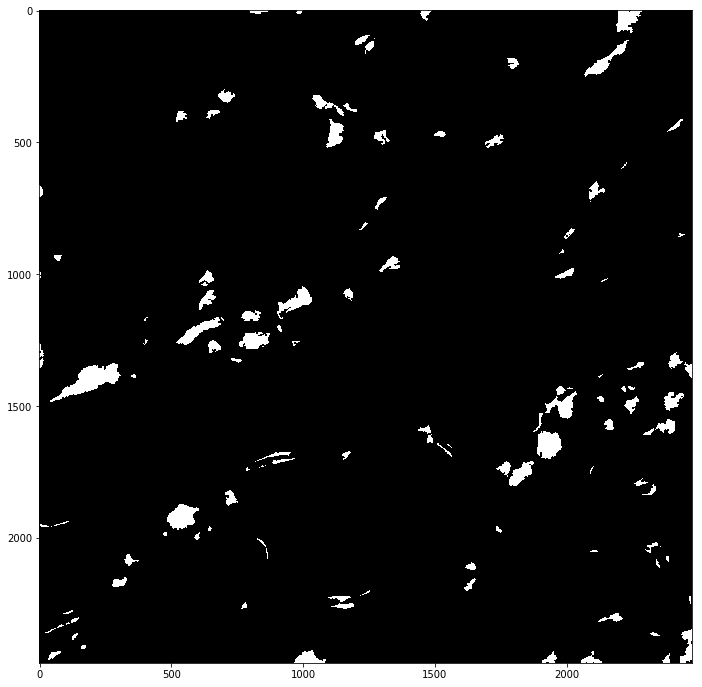

In [164]:
good_contours_small = utils_extra.filter_contours_by_size(
    mode_s_small,
    min_size=17 * 17,
    max_size=(img_shape[0] * img_shape[1]) * .05
)

single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(single_cnt_mask, good_contours_small, -1, 255, -1)

fig = plt.figure(figsize=fig_size)
plt.imshow(single_cnt_mask, cmap='gray')

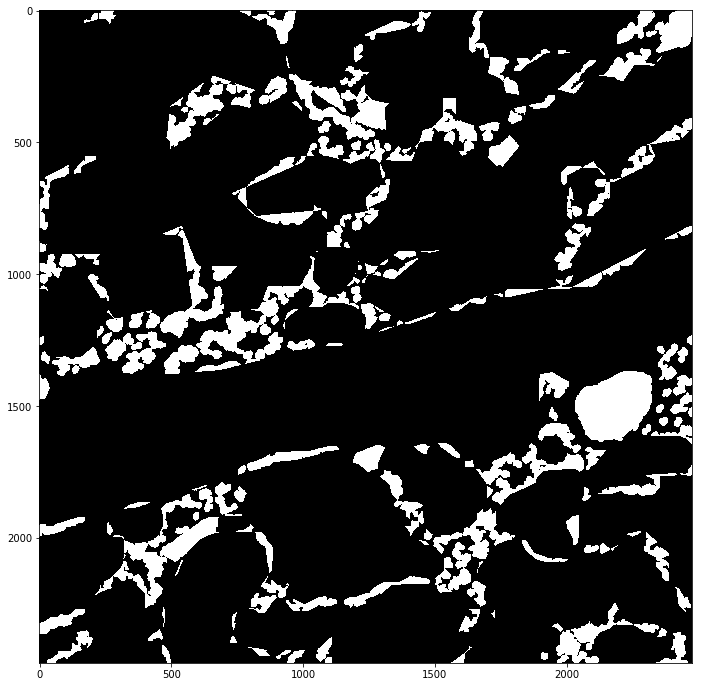

In [165]:
edge_mask = cv2.bitwise_and(edge_mask, edge_mask, mask=~final_med_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(edge_mask, cmap='gray')

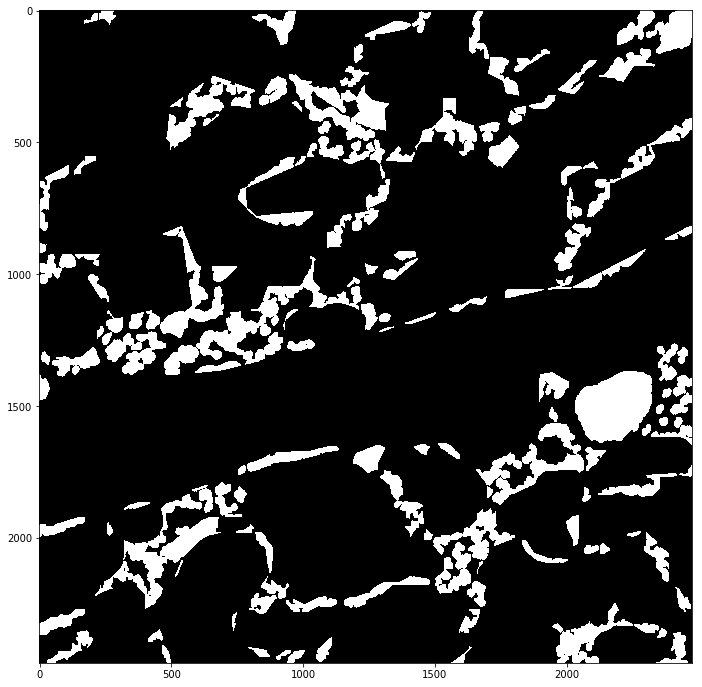

In [166]:
contours = utils_extra.filter_contours_by_size(edge_mask, min_size=31*31)

edge_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 255, -1)

edge_mask = cv2.dilate(edge_mask, (3, 3), iterations=3)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

In [167]:
final_small_sat_val_contours = []

for i, c in enumerate(good_contours_small):
    filled_c_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(filled_c_mask, [c], -1, 255, cv2.FILLED)
    
    new_mask, signal, orig = find_border_by_mask(
        edge_mask, 
        filled_c_mask,
        max_dilate_percentage=2.5,
        dilate_iterations=1
    )
    
    print(i, '\t', signal)
    
    if not orig and signal > 0.7:
        _, contours, _ = cv2.findContours(
            new_mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        final_small_sat_val_contours.append(contours[0])
    elif signal > 0.7:
        final_small_sat_val_contours.append(c)
    else:
        pass  # ignore contour

0 	 0.52
1 	 0.4005602240896359
2 	 0.5981308411214953
3 	 0.5652173913043478
4 	 0.6004140786749482
5 	 0.6945812807881774
6 	 0.27611940298507465
7 	 0.5153846153846153
8 	 0.6467889908256881
9 	 0.7412280701754386
10 	 0.8666666666666667
11 	 0.6880466472303207
12 	 0.4383561643835616
13 	 0.5
14 	 0.44404332129963897
15 	 0.0
16 	 0.6089743589743589
17 	 0.4231433506044905
18 	 0.5220588235294118
19 	 0.5867346938775511
20 	 0.6134453781512605
21 	 0.5538847117794486
22 	 0.9444444444444444
23 	 0.5432692307692307
24 	 0.5824175824175825
25 	 0.7368421052631579
26 	 0.704225352112676
27 	 1.0
28 	 1.0
29 	 0.4863636363636364
30 	 0.5350553505535055
31 	 1.0
32 	 0.9327146171693735
33 	 0.7317073170731707
34 	 0.8368932038834952
35 	 0.9575070821529745
36 	 0.4128878281622912
37 	 0.7295918367346939
38 	 0.3409090909090909
39 	 1.0
40 	 0.8641188959660298
41 	 0.8563218390804598
42 	 0.8256410256410256
43 	 0.8978583196046128
44 	 0.0
45 	 1.0
46 	 0.6787878787878788
47 	 0.62102473

In [168]:
len(final_small_sat_val_contours)

41

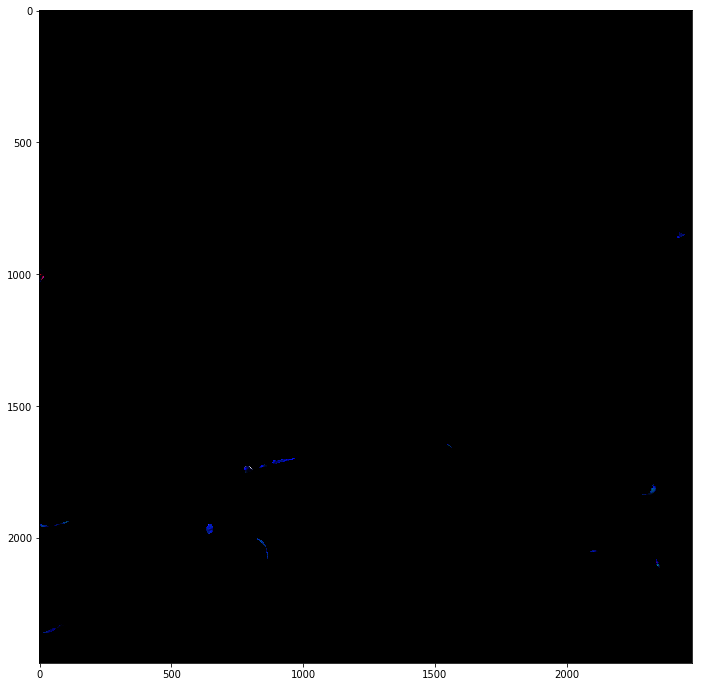

In [169]:
small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)

tmp_small_sat_val_contours = final_small_sat_val_contours.copy()
final_small_sat_val_contours = []

for c in tmp_small_sat_val_contours:
    area = cv2.contourArea(c)
    if area <= 729:
        cv2.drawContours(small_sat_val_mask, [c], -1, 255, cv2.FILLED)
    else:
        final_small_sat_val_contours.append(c)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

In [170]:
len(final_small_sat_val_contours)

27

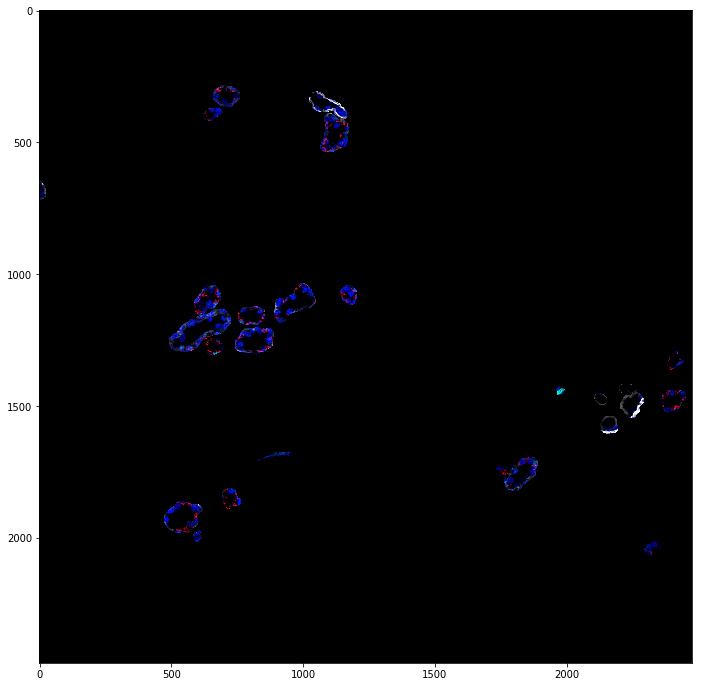

In [171]:
small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(small_sat_val_mask, final_small_sat_val_contours, -1, 255, cv2.FILLED)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

In [172]:
# The previous contours represent the final count of contours for the large sat-val group, 
# but not their final shape/size. The final step is to use approxPolyDP, followed 
# by a few more dilations, but we won't re-draw and extract the contours, as that
# would possibly connect some of them together. However, we will draw them for
# the mask to exclude these regions from the next group of candidates
_, contours, _ = cv2.findContours(
    small_sat_val_mask,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

final_small_sat_val_contours = []

for c in contours:
    peri = cv2.arcLength(c, True)
    smooth_c = cv2.approxPolyDP(c, 0.007 * peri, True)

    single_cnt_mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(single_cnt_mask, [smooth_c], 0, 255, -1)

    # erode & dilate
    single_cnt_mask = cv2.dilate(single_cnt_mask, np.ones((3, 3)), iterations=10)
    
    _, tmp_contours, _ = cv2.findContours(
        single_cnt_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    final_small_sat_val_contours.append(tmp_contours[0])

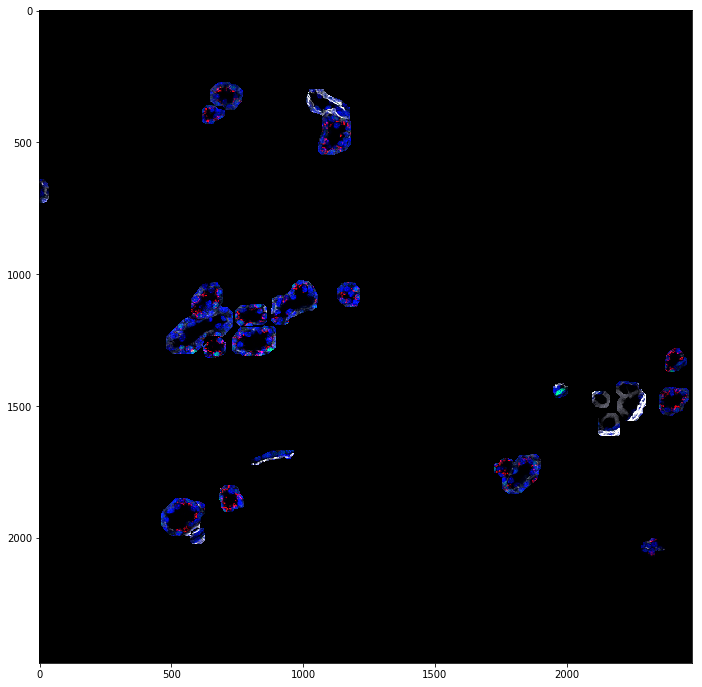

In [173]:
# final color mask to use for exclusion from further groups
final_small_sat_val_mask = np.zeros(img_shape, dtype=np.uint8)
cv2.drawContours(final_small_sat_val_mask, final_small_sat_val_contours, -1, 255, -1)

small_sat_val_img = cv2.bitwise_and(img_rgb, img_rgb, mask=final_small_sat_val_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(small_sat_val_img)

## Merge all candidates

In [174]:
all_contours = final_color_contours + final_large_sat_val_contours + final_med_sat_val_contours +final_small_sat_val_contours

In [175]:
len(all_contours)

52

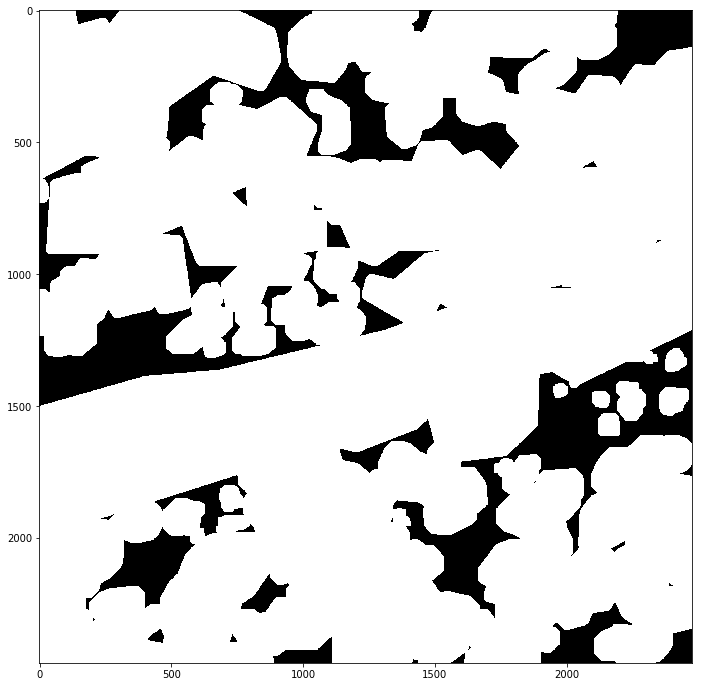

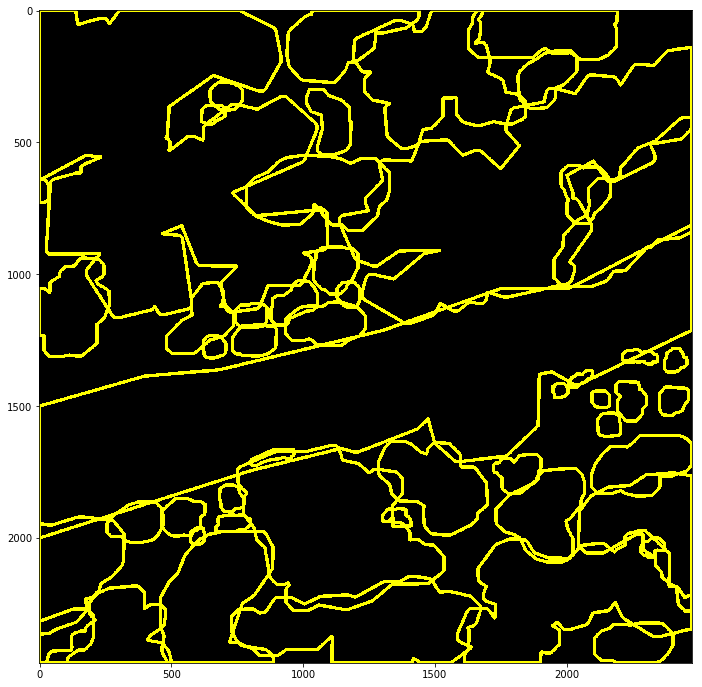

In [176]:
filled_c_mask = np.zeros(img_s.shape, dtype=np.uint8)
border_mask = np.zeros(img_rgb.shape, dtype=np.uint8)

for c in all_contours:    
    cv2.drawContours(filled_c_mask, [c], 0, 255, cv2.FILLED)
    cv2.drawContours(border_mask, [c], 0, (255, 255, 0), 11)
    
fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(filled_c_mask, cv2.COLOR_GRAY2RGB))

fig = plt.figure(figsize=fig_size)
plt.imshow(border_mask)

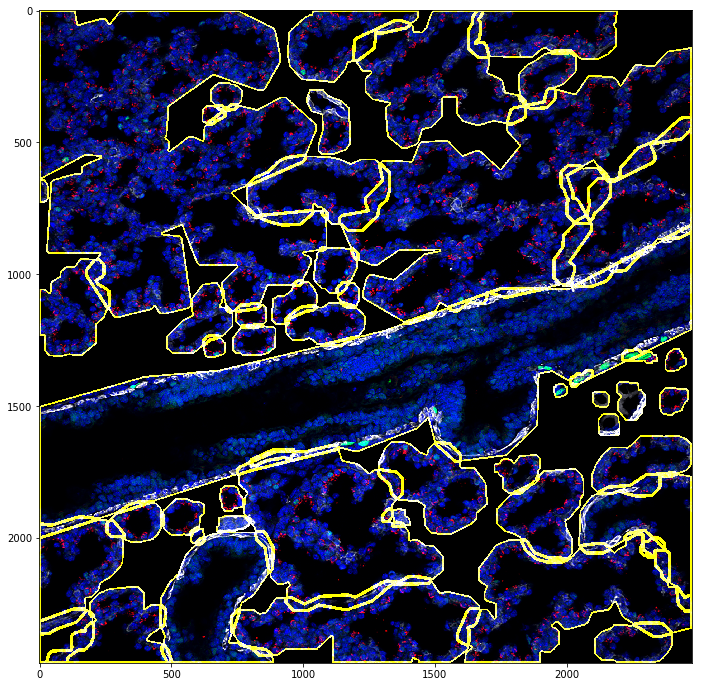

In [177]:
final_candidate_img = cv2.bitwise_or(img_rgb, border_mask, mask=filled_c_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_candidate_img)

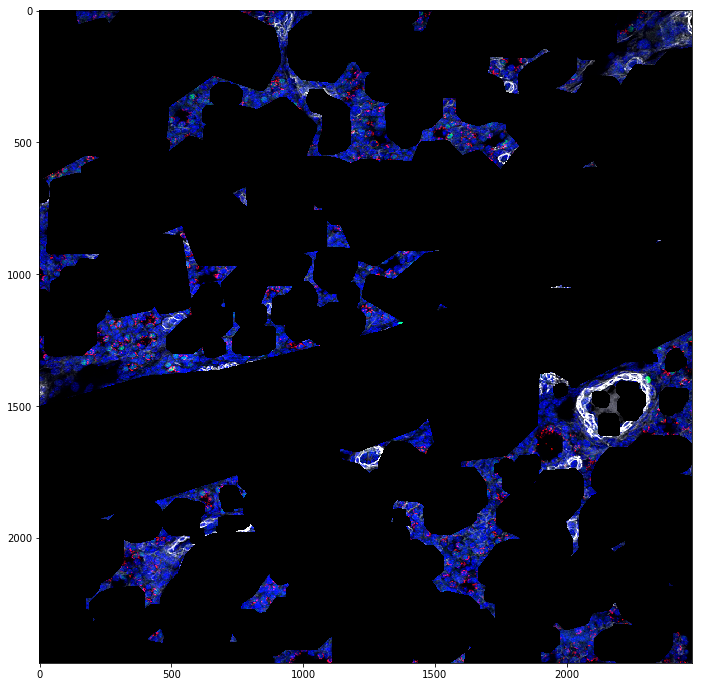

In [178]:
final_non_candidate_img = cv2.bitwise_and(img_rgb, img_rgb, mask=~filled_c_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(final_non_candidate_img)